In [187]:
# Assignment 1 - Steady-State Conduction

#Solve each of the following problems and explain your results. For each problem, determine an appropriate number of control volumes through a grid independence study. Determine the number of iterations required for convergence and comment on the result.

## Problem 1 - Linear Heat Conduction

Solve for the one-dimensional temperature distribution in a square bar of mild steel as given below. The properties of mild steel are:

 - $k$ = 60 [W/m$\cdot$K]
 - $\rho$ = 7800 [kg/m$^3$]
 - $c_p$ = 430 [J/kg$\cdot$K]
 
Assume the convection coefficient is zero on the exposed surfaces, and fixed end temperatures of $T_1$ =100 [$^\circ$C] and $T_2$ = 0 [$^\circ$C].

![SquareBar](Figures/1-SquareBar.png)

In [188]:
## CLASSES DEFINED TO BE USED IN ALL THE PROBLEMS

##Grid definition

import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [189]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [190]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2
    

In [191]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [192]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [193]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [251]:
#Problem 1 for a number of control volumes of 15

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 15
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373.15, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273.15, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 45.06749999999999; Avg. Resid. = 3.0089999999999986
Iteration = 1; Max. Resid. = 1.2878587085651816e-14; Avg. Resid. = 6.824170858029296e-15


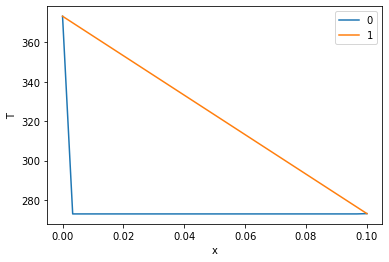

[0.         0.00333333 0.01       0.01666667 0.02333333 0.03
 0.03666667 0.04333333 0.05       0.05666667 0.06333333 0.07
 0.07666667 0.08333333 0.09       0.09666667 0.1       ]
[array([373.15, 273.  , 273.  , 273.  , 273.  , 273.  , 273.  , 273.  ,
       273.  , 273.  , 273.  , 273.  , 273.  , 273.  , 273.  , 273.  ,
       273.15]), array([373.15      , 369.81666667, 363.15      , 356.48333333,
       349.81666667, 343.15      , 336.48333333, 329.81666667,
       323.15      , 316.48333333, 309.81666667, 303.15      ,
       296.48333333, 289.81666667, 283.15      , 276.48333333,
       273.15      ])]


In [252]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_1 = T_solns.copy()
grid1_xP = grid.xP

print(grid.xP)
print(T_solns_1)

In [237]:
#Problem 1 for a number of control volumes of 30

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373.15, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273.15, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 90.13499999999998; Avg. Resid. = 3.0089999999999986
Iteration = 1; Max. Resid. = 3.197442310920451e-14; Avg. Resid. = 1.295260195396016e-14


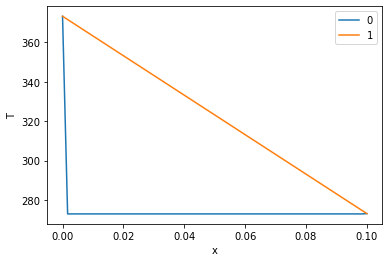

In [238]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_2 = T_solns.copy()
grid2_xP=grid.xP

In [239]:
#Problem 1 for a number of control volumes of 60

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 60
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373.15, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273.15, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 180.26999999999995; Avg. Resid. = 3.0089999999999986
Iteration = 1; Max. Resid. = 9.614531393253856e-14; Avg. Resid. = 2.903973358077868e-14


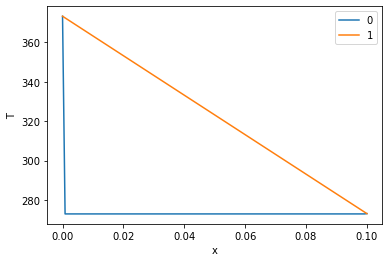

In [240]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_3 = T_solns.copy()
grid3_xP=grid.xP

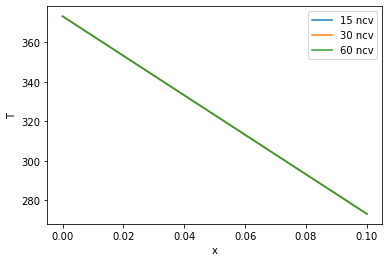

In [255]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()

ax.plot(grid1_xP, T_solns_1[-1], label="15 ncv")
ax.plot(grid2_xP, T_solns_2[-1], label="30 ncv")
ax.plot(grid3_xP, T_solns_3[-1], label="60 ncv")


ax.set_xlabel("x")
ax.set_ylabel("T")
ax.legend()
plt.show()

## Problem 2 - External Convection

Consider the same geometry and properties as in problem 1, except use $h$ = 12 [W/m$^2\cdot$K] for the exposed surfaces of the bar, and end temperatures of $T_1$ = $T_2$ = 100 [$^\circ$C].  Assume the surrounding air to be at $T_{\infty}$ = 25 [$^\circ$C]. Obtain the solution for this problem and compare your solution to the analytical solution.


In [ ]:
Using previous classes definitions, we will just add the Surface Convection Model and redefine the
new data to this external convection problem

In [259]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        
        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [267]:
#Problem 2 for a number of control values of 15

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 273.15+25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 30.06036; Avg. Resid. = 6.0603599999999975
Iteration = 1; Max. Resid. = 1.5015766408055242e-14; Avg. Resid. = 9.43689570931383e-15


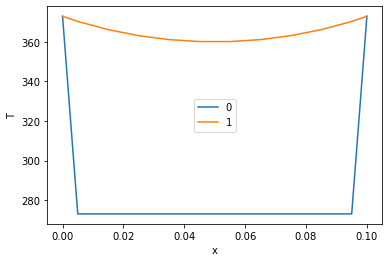

In [268]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_1 = T_solns.copy()
grid1_xP=grid.xP

In [269]:
#Problem 2 for a number of control volumes of 30

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 273.15+25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 90.02012000000018; Avg. Resid. = 6.020120000000007
Iteration = 1; Max. Resid. = 4.819755705653961e-14; Avg. Resid. = 2.0317312647103828e-14


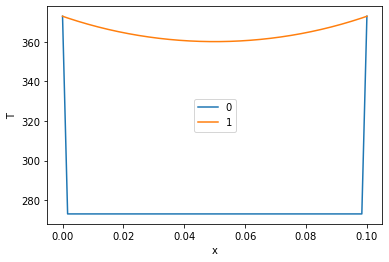

In [270]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_2 = T_solns.copy()
grid2_xP=grid.xP

In [271]:
#Problem 2 for a number of control volumes of 60

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 60
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 273.15+25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 180.01006000000183; Avg. Resid. = 6.010060000000032
Iteration = 1; Max. Resid. = 8.619840952128754e-14; Avg. Resid. = 3.3378566114776004e-14


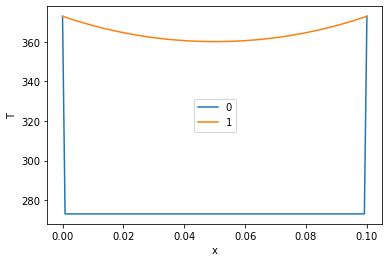

In [272]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_3 = T_solns.copy()
grid3_xP=grid.xP

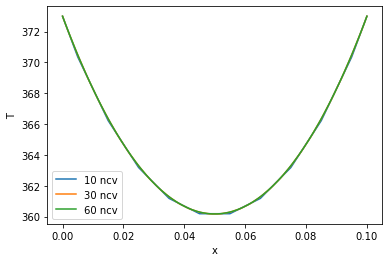

In [279]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2, ax = plt.subplots()

ax.plot(grid1_xP, T_solns_1[-1], label="10 ncv")
ax.plot(grid2_xP, T_solns_2[-1], label="30 ncv")
ax.plot(grid3_xP, T_solns_3[-1], label="60 ncv")


ax.set_xlabel("x")
ax.set_ylabel("T")
ax.legend()
plt.show()

## Problem 3 - Internal Heat Generation

A plane wall $L$ = 0.1 [m] thick with a thermal conductivity of $k$ = 26 [W/m$\cdot$K] is exposed to an environment at an ambient temperature of 50 [$^\circ$C] on one side and an environment of 40 [$^\circ$C] on the other side. The convection coefficient at the exposed surfaces is estimated to be $h$ = 280 [W/m$^2\cdot$K]. If heat is generated uniformly within the wall at a rate 50,000 [W/m$^3$], determine the surface temperatures of the walls, and the location and value of the maximum temperature inside the wall. Compare your result to the analytical result, which can be obtained from a heat transfer textbook.

In [219]:
##Using the same previous classes defined, in this case considering the set up of the boundary conditions
# and the conditions of the source, the following classes are developed:


class RobinBc:
    """Class defining a Robin boundary condifiton"""
    
    def __init__ (self,phi,grid,ho,k,To,loc):
        
        self._phi = phi
        self._grid = grid
        self._ho = ho
        self._k = k
        self._To = To
        self._loc = loc
    
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + ((self._ho/self._k)*self._grid.dx_WP[0]*self._To))*(1/(1+((self._ho/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + ((self._ho/self._k)*self._grid.dx_PE[-1]*self._To))*(1/(1+((self._ho/self._k)*self._grid.dx_PE[-1])))
        else:
            raise ValueError("Unknown boundary condition")
            
    def coeff(self):
        """Returns the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1/(1+((self._ho/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            return (1/(1+((self._ho/self._k)*self._grid.dx_PE[-1])))
        else: 
            raise ValueError("Unknown boundary condition")
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + ((self._ho/self._k)*self._grid.dx_WP[0]*self._To))*(1/(1+((self._ho/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + ((self._ho/self._k)*self._grid.dx_PE[-1]*self._To))*(1/(1+((self._ho/self._k)*self._grid.dx_PE[-1])))
        else:
            raise ValueError("Unknown boundary condition")

In [220]:
class InternalConvection:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, qo):
        
        """Constructor"""
        self._grid = grid
        self._qo = qo
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source =  -qo*self._grid.vol
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs
    

In [221]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 100
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ho = 280

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 323

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = RobinBc(T, grid, ho, 323, k, BoundaryLocation.WEST) #phi,ho,k,To_E,To_W,loc)
east_bc = RobinBc(T, grid, ho, 313, k, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
qo=50000
Internal = InternalConvection(grid, qo)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = Internal.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 0.17136927572325802; Avg. Resid. = 0.004598966168138882
[135.24984278 135.29719565 135.38997832 135.48083791 135.56977443
 135.65678787 135.74187823 135.82504551 135.90628972 135.98561085
 136.0630089  136.13848388 136.21203578 136.2836646  136.35337035
 136.42115302 136.48701261 136.55094913 136.61296256 136.67305293
 136.73122021 136.78746442 136.84178555 136.8941836  136.94465858
 136.99321048 137.0398393  137.08454505 137.12732772 137.16818731
 137.20712382 137.24413726 137.27922762 137.31239491 137.34363912
 137.37296025 137.4003583  137.42583328 137.44938518 137.471014
 137.49071975 137.50850242 137.52436201 137.53829852 137.55031196
 137.56040232 137.56856961 137.57481382 137.57913495 137.581533
 137.58200798 137.58055988 137.5771887  137.57189445 137.56467711
 137.55553671 137.54447322 137.53148666 137.51657702 137.49974431
 137.48098851 137.46030964 137.4377077  137.41318268 137.38673458
 137.3583634  137.32806914 137.29585181 137.26171141 137.2256

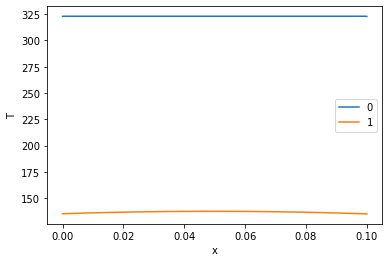

In [222]:
##POST PROCESSING

%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

## Problem 4 - Radiation 

Solve the following problem using the square bar geometry given in question 1 with $T_\infty$ = 0 [K]. Assume that the convection coefficient is $h$ = 0 [W/m$^2\cdot$K], the emmisivity is $\epsilon$ = 1.0, the end temperatures are $T_1$ = 400 [K] and $T_2$ = 0 [K]. Try solving this problem using the following linearizations of the radiation source term:

- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and do not include any contribution from this term into the Jacobian matrix. This is an explicit implementation of the source term.
- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and include the linearizaton $\partial q_o^{\prime\prime}/\partial T$ into the Jacobian matrix. This is an implicit implementation of the source term.

Solve using each linearization assuming the material is:

- Steel, for which: $k$ = 60 [W/m$\cdot$K], $c_p$ = 430 [J/kg$\cdot$K]
- Wood, for which: $k$ = 0.1 [W/m$\cdot$K], $c_p$ = 1.3 [J/kg$\cdot$K]

Explain any differences that you observe.

In [223]:


class SurfaceRadiationModelExplicit:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Ep, Sig, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Ep = Ep
        self._Sig = Sig
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._Ep*self._Sig*((self._T[1:-1])**4 - self._To**4)
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [230]:
class SurfaceRadiationModelImplicit:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Ep, Sig, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Ep = Ep
        self._Sig = Sig
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = -(self._Ep*self._Sig*((self._T[1:-1])**4 - self._To**4))
        
        # Calculate the linearization coefficients
        coeffP = (self._Ep*self._Sig*4)*((self._T[1:-1])**3)
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [234]:
## FOR STEEL

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 100
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=(5.67)*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationEx = SurfaceRadiationModelExplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationEx.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 5492.699999999999; Avg. Resid. = 4598.7
Iteration = 1; Max. Resid. = 1.216299454108287e+20; Avg. Resid. = 4.9445082561688175e+19
Iteration = 2; Max. Resid. = 8.445641873664052e+84; Avg. Resid. = 2.8594359405213546e+84
Iteration = 3; Max. Resid. = inf; Avg. Resid. = inf
Iteration = 4; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 5; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 6; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 7; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 8; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 9; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 10; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 11; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 12; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 13; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 14; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 15; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 16; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 17; Ma

<ipython-input-223-881613192e0f>:16: RuntimeWarning: overflow encountered in power
  source = self._Ep*self._Sig*((self._T[1:-1])**4 - self._To**4)


Iteration = 157; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 158; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 159; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 160; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 161; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 162; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 163; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 164; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 165; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 166; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 167; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 168; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 169; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 170; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 171; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 172; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 173; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 174; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 175; Max. Resid.

In [235]:
## FOR STEEL

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 100
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 4892.7; Avg. Resid. = 4586.7
Iteration = 1; Max. Resid. = 11419.703740503302; Avg. Resid. = 11184.42201724168
Iteration = 2; Max. Resid. = 27380.957678145292; Avg. Resid. = 27286.554592069228
Iteration = 3; Max. Resid. = 66837.2135531316; Avg. Resid. = 66591.48595713616
Iteration = 4; Max. Resid. = 163167.16163991485; Avg. Resid. = 162542.24822747015
Iteration = 5; Max. Resid. = 398357.26804412354; Avg. Resid. = 396786.47084827983
Iteration = 6; Max. Resid. = 972551.8558908512; Avg. Resid. = 968658.6688976247
Iteration = 7; Max. Resid. = 2374394.1011566436; Avg. Resid. = 2364814.7184319557
Iteration = 8; Max. Resid. = 5796860.505863949; Avg. Resid. = 5773378.497920739
Iteration = 9; Max. Resid. = 14152491.357168224; Avg. Resid. = 14095042.049203156
Iteration = 10; Max. Resid. = 34551980.714588165; Avg. Resid. = 34411571.78015454
Iteration = 11; Max. Resid. = 84355421.49571124; Avg. Resid. = 84012434.87288971
Iteration = 12; Max. Resid. = 205945853.04858106;

Iteration = 162; Max. Resid. = 2.8824438483036523e+66; Avg. Resid. = 2.8707169811693628e+66
Iteration = 163; Max. Resid. = 7.037216426522587e+66; Avg. Resid. = 7.00858637980801e+66
Iteration = 164; Max. Resid. = 1.7180704166314916e+67; Avg. Resid. = 1.7110806591328148e+67
Iteration = 165; Max. Resid. = 4.194507853104228e+67; Avg. Resid. = 4.1774430154609733e+67
Iteration = 166; Max. Resid. = 1.0240497688242744e+68; Avg. Resid. = 1.0198835486965267e+68
Iteration = 167; Max. Resid. = 2.500121505918639e+68; Avg. Resid. = 2.48995007005988e+68
Iteration = 168; Max. Resid. = 6.1038122703091775e+68; Avg. Resid. = 6.078979663232129e+68
Iteration = 169; Max. Resid. = 1.490188542555952e+69; Avg. Resid. = 1.4841258943437811e+69
Iteration = 170; Max. Resid. = 3.6381556214744926e+69; Avg. Resid. = 3.6233542342377466e+69
Iteration = 171; Max. Resid. = 8.88221587274046e+69; Avg. Resid. = 8.846079673431999e+69
Iteration = 172; Max. Resid. = 2.168509734555776e+70; Avg. Resid. = 2.1596874202714837e+70
I